In [1]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.distributions.uniform import Uniform
from torch.utils.data import TensorDataset, DataLoader

import lightning as L

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Troll 2 is great.
# Gymkata is great.

#    1   ,  0,   0  ,   0
# Troll 2, is, great, Gymkata

inputs = torch.tensor([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
])
labels = torch.tensor([
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
    [0.0, 1.0, 0.0, 0.0],
])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [ ]:
class WordEmbeddingFromScratch(L.LightningModule):
    def __init__(self):
        super().__init__()

        min_value = -0.5
        max_value = 0.5

        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.loss = nn.CrossEntropyLoss()

    def forward(self, input):
        input = input[0]

        input_to_top_hidden = (
            (input[0] * self.input1_w1) + 
            (input[1] * self.input2_w1) + 
            (input[2] * self.input3_w1) + 
            (input[3] * self.input4_w1)
        )
        input_to_bottom_hidden = (
            (input[0] * self.input1_w2) + 
            (input[1] * self.input2_w2) + 
            (input[2] * self.input3_w2) + 
            (input[3] * self.input4_w2)
        )

        output1 = ((input_to_top_hidden * self.output1_w1) + (input_to_bottom_hidden * self.output1_w2))
        output2 = ((input_to_top_hidden * self.output2_w1) + (input_to_bottom_hidden * self.output2_w2))
        output3 = ((input_to_top_hidden * self.output3_w1) + (input_to_bottom_hidden * self.output3_w2))
        output4 = ((input_to_top_hidden * self.output4_w1) + (input_to_bottom_hidden * self.output4_w2))

        output_pre_softmax = torch.stack([output1, output2, output3, output4])
        return output_pre_softmax

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)
    
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i[0])
        return loss

In [26]:
model = WordEmbeddingFromScratch()
print("Before optimizing, Parametesrs: ")
for name, param in model.named_parameters():
    print(name, param.data)
    

Before optimizing, Parametesrs: 
input1_w1 tensor(0.2108)
input1_w2 tensor(0.4891)
input2_w1 tensor(-0.2470)
input2_w2 tensor(-0.2718)
input3_w1 tensor(0.2381)
input3_w2 tensor(-0.1433)
input4_w1 tensor(0.2484)
input4_w2 tensor(0.4647)
output1_w1 tensor(-0.4579)
output1_w2 tensor(-0.1395)
output2_w1 tensor(0.3309)
output2_w2 tensor(-0.4670)
output3_w1 tensor(0.4391)
output3_w2 tensor(0.3743)
output4_w1 tensor(0.2935)
output4_w2 tensor(0.1581)


In [27]:
data = {
    "w1" : [
        model.input1_w1.item(),
        model.input2_w1.item(),
        model.input3_w1.item(),
        model.input4_w1.item(),
        ],
    "w2" : [
        model.input1_w2.item(),
        model.input2_w2.item(),
        model.input3_w2.item(),
        model.input4_w2.item(),
        ],
    "token": ['Troll 2', 'is', 'great', 'Gymkata'],
    "input": ['input1', 'input2', 'input3', 'input4'],

}
df = pd.DataFrame(data)
df

,w1,w2,token,input
0,0.210836,0.489101,Troll 2,input1
1,-0.246999,-0.271806,is,input2
2,0.238071,-0.143343,great,input3
3,0.248366,0.464690,Gymkata,input4


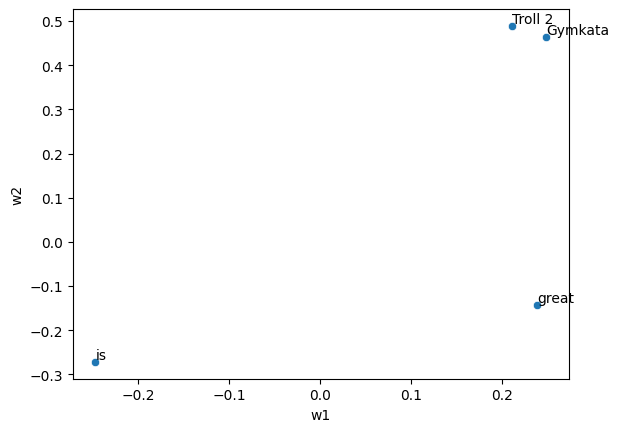

In [28]:
# let's see the difference in values through a scatterplot
sns.scatterplot(data=df, x='w1', y='w2')
for i in range(4):
    plt.text(df.w1[i], df.w2[i], df.token[i], verticalalignment='bottom', size='medium', color='black')

In [29]:
trainer = L.Trainer(max_epochs=300)
trainer.fit(model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | CrossEntropyLoss | 0      | train
  | other params | n/a              | 16     | n/a  
----------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
c:\Users\11ukn\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\11ukn\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(l

Epoch 299: 100%|██████████| 4/4 [00:00<00:00, 172.51it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 4/4 [00:00<00:00, 120.86it/s, v_num=0]


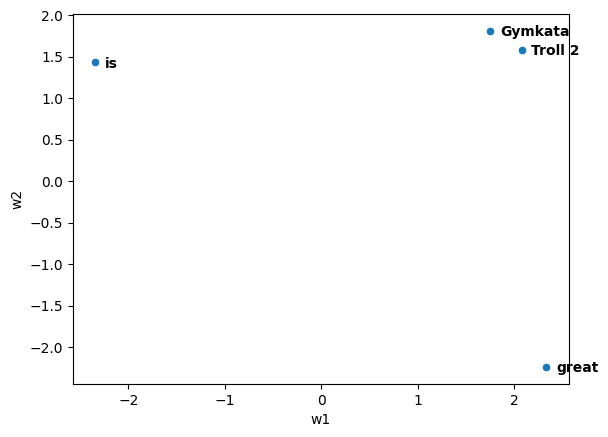

In [ ]:
data = {
    "w1" : [
        model.input1_w1.item(),
        model.input2_w1.item(),
        model.input3_w1.item(),
        model.input4_w1.item(),
        ],
    "w2" : [
        model.input1_w2.item(),
        model.input2_w2.item(),
        model.input3_w2.item(),
        model.input4_w2.item(),
        ],
    "token": ['Troll 2', 'is', 'great', 'Gymkata'],
    "input": ['input1', 'input2', 'input3', 'input4']
}
df = pd.DataFrame(data)
df

# let's see the difference in values through a scatterplot
sns.scatterplot(data=df, x='w1', y='w2')
for i in range(4):
    plt.text(df.w1[i] + 0.1, df.w2[i] - 0.1, df.token[i], verticalalignment='bottom', size='medium', color='black', weight='semibold')

In [40]:
softmax = nn.Softmax(dim=0)
print(torch.round(softmax(model(torch.tensor([[0., 0., 0., 1.]]))),decimals=2))

tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)


In [58]:
class WordEmbeddingAdv(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.input_to_hidden = nn.Linear(in_features=4, out_features=2, bias=False)
        self.hidden_to_output = nn.Linear(in_features=2, out_features=4, bias=False)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input):
        hidden = self.input_to_hidden(input)
        output_values = self.hidden_to_output(hidden)
        return output_values

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)
    
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i)
        return loss

In [59]:
modelLinear = WordEmbeddingAdv()
data = {
    'w1': modelLinear.input_to_hidden.weight.detach()[0].numpy(),
    'w2': modelLinear.input_to_hidden.weight.detach()[1].numpy(),
    "token": ['Troll 2', 'is', 'great', 'Gymkata'],
    "input": ['input1', 'input2', 'input3', 'input4']
}
df = pd.DataFrame(data)

In [60]:
df

,w1,w2,token,input
0,-0.344698,0.269829,Troll 2,input1
1,-0.253176,0.306896,is,input2
2,-0.460009,-0.135500,great,input3
3,0.160369,0.395153,Gymkata,input4


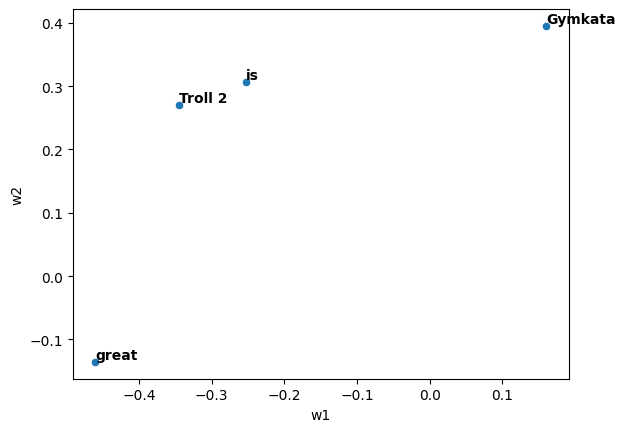

In [ ]:
sns.scatterplot(data=df, x='w1', y='w2')
for i in range(4):
    plt.text(df.w1[i], df.w2[i], df.token[i], verticalalignment='bottom', size='medium', color='black', weight='semibold')      

In [62]:
trainer = L.Trainer(max_epochs=150)
trainer.fit(modelLinear, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | input_to_hidden  | Linear           | 8      | train
1 | hidden_to_output | Linear           | 8      | train
2 | loss             | CrossEntropyLoss | 0      | train
--------------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
c:\Users\11ukn\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\User

Epoch 2:  25%|██▌       | 1/4 [00:00<00:00, 96.81it/s, v_num=4] 

Epoch 149: 100%|██████████| 4/4 [00:00<00:00, 125.85it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 4/4 [00:00<00:00, 119.80it/s, v_num=4]


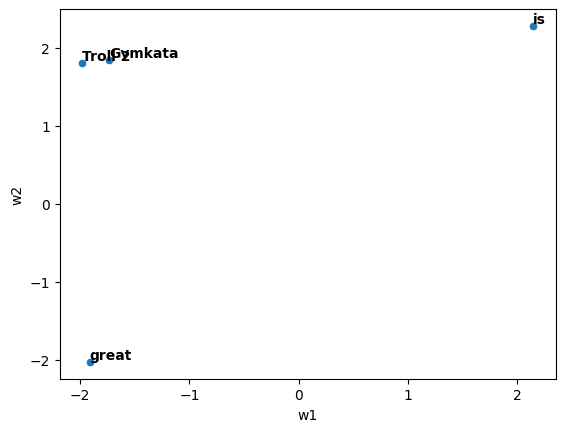

In [63]:
data = {
    'w1': modelLinear.input_to_hidden.weight.detach()[0].numpy(),
    'w2': modelLinear.input_to_hidden.weight.detach()[1].numpy(),
    "token": ['Troll 2', 'is', 'great', 'Gymkata'],
    "input": ['input1', 'input2', 'input3', 'input4']
}
df = pd.DataFrame(data)

sns.scatterplot(data=df, x='w1', y='w2')
for i in range(4):
    plt.text(df.w1[i], df.w2[i], df.token[i], verticalalignment='bottom', size='medium', color='black', weight='semibold')